In [1]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import os
import csv
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import multiprocessing as mp
mp.set_start_method("fork")

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['Solarize_Light2', '_classic_test_patch', 'arviz-bluish', 'arviz-brownish', 'arviz-colors', 'arviz-cyanish', 'arviz-darkgrid', 'arviz-grayscale', 'arviz-greenish', 'arviz-orangish', 'arviz-plasmish', 'arviz-purplish', 'arviz-redish', 'arviz-royish', 'arviz-viridish', 'arviz-white', 'arviz-whitegrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [2]:
class Ornstein_Uhlenbeck(pm.Continuous):
    """
    Ornstein-Uhlenbeck Process
    Parameters
    ----------
    B : tensor
        B > 0, B = exp(-(D/A)*delta_t)
    A : tensor
        A > 0, amplitude of fluctuation <x**2>=A
    delta_t: scalar
        delta_t > 0, time step
    """
    
    def __init__(self, A=None, B=None,
                 *args, **kwargs):
        super(Ornstein_Uhlenbeck, self).__init__(*args, **kwargs)
        self.A = A
        self.B = B
        self.mean = 0.
    
    def logp(self, x):
        A = self.A
        B = self.B
        
        x_im1 = x[:-1]
        x_i = x[1:]
        
        ou_like = pm.Normal.dist(mu=x_im1*B, tau=1.0/A/(1-B**2)).logp(x_i)
        return pm.Normal.dist(mu=0.0,tau=1.0/A).logp(x[0]) + tt.sum(ou_like)

In [3]:
currentdir = os.getcwd()
datadir = os.path.join(currentdir,'OxytocinRSData_new')
print(datadir)

/Users/hstrey/Documents/programming/fMRI-analysis/OxytocinRSData_new


In [4]:
# get data files names
datafilenames = os.listdir(datadir)
print(datafilenames)

['.DS_Store', 'Subject002.npy', 'Subject003.npy', 'Subject001.npy', 'Subject004.npy', 'Subject005.npy']


In [5]:
a_bound = 20
delta_t = 0.802
results = None
for datafilename in datafilenames:
    if datafilename.endswith('.npy'):
        time_series = np.load(os.path.join(datadir,datafilename),allow_pickle=True)
    else:
        continue
    mpfc = time_series[:,0]
    llp = time_series[:,1]
    rlp = time_series[:,2]
    pcc = time_series[:,3]
    
    x1 = rlp
    x2 = llp
    
    x1 = x1/x1.std()
    x2 = x2/x2.std()
    
    prho = pearsonr(x1,x2)[0]
    print("pearson: ",prho)
    
    coupling = 2*np.abs(prho)/(1-np.abs(prho))*np.sign(prho)

    y1 = x1 + x2
    y2 = x1 - x2
    with pm.Model() as model:
        A1 = pm.Uniform('A1', lower=0, upper=a_bound)
        A2 = pm.Uniform('A2', lower=0, upper=a_bound)
        D = pm.Uniform('D',lower=0,upper=20)
            
        B1 = pm.Deterministic('B1',pm.math.exp(-delta_t * D / A1))
        B2 = pm.Deterministic('B2',pm.math.exp(-delta_t * D / A2))
                                
        path1 = Ornstein_Uhlenbeck('path1',A=A1, B=B1,shape=len(y1),observed=y1)
        path2 = Ornstein_Uhlenbeck('path2',A=A2, B=B2,shape=len(y2),observed=y2)
                                
        trace = pm.sample(10000,tune=2000,chains=1,cores=1)

    A1_trace = trace['A1']
    A2_trace = trace['A2']
    A1_mean = np.mean(A1_trace)
    A2_mean = np.mean(A2_trace)
    dA1 = np.std(A1_trace)
    dA2 = np.std(A2_trace)
    
    D_trace = trace['D']
    D_mean = np.mean(D_trace)
    dD = np.std(D_trace)

    dA1A2 = np.cov(A1_trace,A2_trace)[0,1]
    dA1D = np.cov(A1_trace,D_trace)[0,1]
    dA2D = np.cov(A2_trace,D_trace)[0,1]
    
    C_trace = (A1_trace-A2_trace)/A2_trace
    C_mean = np.mean(C_trace)
    dC = np.std(C_trace)

    print("predicted C: ",C_mean," +- ",dC)

    if results is None:
        results = [coupling,
                   prho,
                   C_mean,
                   dC,
                   A1_mean,
                   dA1,
                   A2_mean,
                   dA2,
                   D_mean,
                   dD,
                   dA1A2,
                   dA1D,
                   dA2D,
                   C_mean,
                   dC
                   ]
    else:
        results = np.vstack((results,
                   [coupling,
                   prho,
                   C_mean,
                   dC,
                   A1_mean,
                   dA1,
                   A2_mean,
                   dA2,
                   D_mean,
                   dD,
                   dA1A2,
                   dA1D,
                   dA2D,
                   C_mean,
                   dC
                   ]))

pearson:  0.7506121401513625


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [D, A2, A1]


Sampling 1 chain for 2_000 tune and 10_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


predicted C:  6.160678027905492  +-  1.8267332511560295
pearson:  0.7718491121830499


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [D, A2, A1]


Sampling 1 chain for 2_000 tune and 10_000 draw iterations (2_000 + 10_000 draws total) took 9 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


predicted C:  6.766405226106856  +-  1.9772619484280565
pearson:  0.702623576186467


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [D, A2, A1]


Sampling 1 chain for 2_000 tune and 10_000 draw iterations (2_000 + 10_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


predicted C:  4.653612946766833  +-  1.0612459830585488
pearson:  0.6391762044442496


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [D, A2, A1]


Sampling 1 chain for 2_000 tune and 10_000 draw iterations (2_000 + 10_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


predicted C:  3.5412646154629583  +-  0.8459087673803214
pearson:  0.7633386931686749


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [D, A2, A1]


Sampling 1 chain for 2_000 tune and 10_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


predicted C:  5.60330328983437  +-  0.9719741890796779


In [6]:
x = ['1','2','3','4','5','population \n average']
results.T[2]

array([6.16067803, 6.76640523, 4.65361295, 3.54126462, 5.60330329])

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  


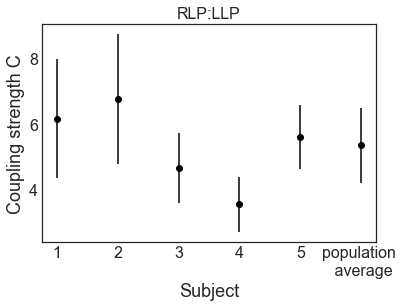

In [7]:
plt.errorbar(x,np.append(results.T[2],[results.T[2].mean()]),
                         yerr=np.append(results.T[3],[results.T[2].std()]),fmt="o",color="k")
plt.title("RLP:LLP")
plt.ylabel("Coupling strength C")
plt.xlabel("Subject")
plt.savefig("rlp_llpMCMC.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [8]:
# now lets do an analysis on the coupling distribution
mc = results.T[2]
stdd = results.T[2].std()
with pm.Model() as distModel:
    C0 = pm.Uniform('C0',0,10)
    S = pm.Uniform('S',0,5)
    CT = pm.Normal('CT',mu=C0,sigma=S,shape=5)
    measured = pm.Normal('measured',mu=CT,sigma=stdd,observed=mc)
    
    trace = pm.sample(10000,tune=2000,chains=1,cores=1)


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [CT, S, C0]


Sampling 1 chain for 2_000 tune and 10_000 draw iterations (2_000 + 10_000 draws total) took 15 seconds.
There were 304 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [9]:
pm.summary(trace)

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
CT[0],5.746,0.908,3.983,7.378,0.021,0.015,1930.0,1930.0,1928.0,4614.0,NaN
CT[1],6.048,0.964,4.285,7.903,0.021,0.015,2089.0,2089.0,2019.0,2911.0,NaN
CT[2],5.023,0.931,3.190,6.652,0.024,0.018,1484.0,1321.0,1420.0,3782.0,NaN
CT[3],4.500,1.016,2.603,6.303,0.032,0.024,1031.0,881.0,919.0,425.0,NaN
CT[4],5.478,0.877,3.841,7.149,0.020,0.014,1911.0,1911.0,1870.0,4584.0,NaN
C0,5.356,0.925,3.626,7.031,0.024,0.017,1492.0,1492.0,1662.0,2440.0,NaN
S,1.341,0.943,0.175,3.136,0.031,0.022,943.0,943.0,433.0,230.0,NaN


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  if __name__ == '__main__':


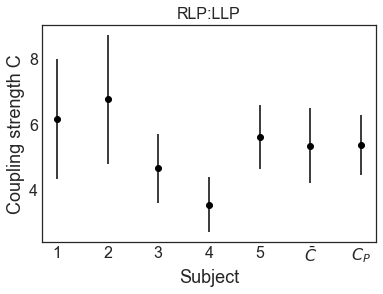

In [11]:
c0 = trace['C0'].mean()
dc0 = trace['C0'].std()
xfig = ['1','2','3','4','5',r'$\bar{C}$',r'$C_{P}$']
plt.errorbar(xfig,np.append(results.T[2],[results.T[2].mean(),c0]),
                         yerr=np.append(results.T[3],[results.T[2].std(),dc0]),fmt="o",color="k")
plt.title("RLP:LLP")
plt.ylabel("Coupling strength C")
plt.xlabel("Subject")
plt.savefig("rlp_llpMCMCPV.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")